In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn import metrics

# load results

In [2]:
dirs = ["const_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [3]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)

index2o = {}
index2t = {}
num = 0
for i, _ in enumerate(lamL1wave_grid):
    for j, _ in enumerate(lamL1attr_grid):
        loc = (lamL1wave == lamL1wave_grid[i]) & (lamL1attr == lamL1attr_grid[j])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index2o[(i,j)] = loc
            index2t[num] = (i,j)
        num += 1
            
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)
psi_list = []
wt_list = []
for r in range(R):
    for c in range(C):
        wt = mos[index2o[(r,c)]]
        wt_list.append(wt)
        phi, psi, x = get_wavefun(wt)
        psi_list.append(psi)            

# Plotting

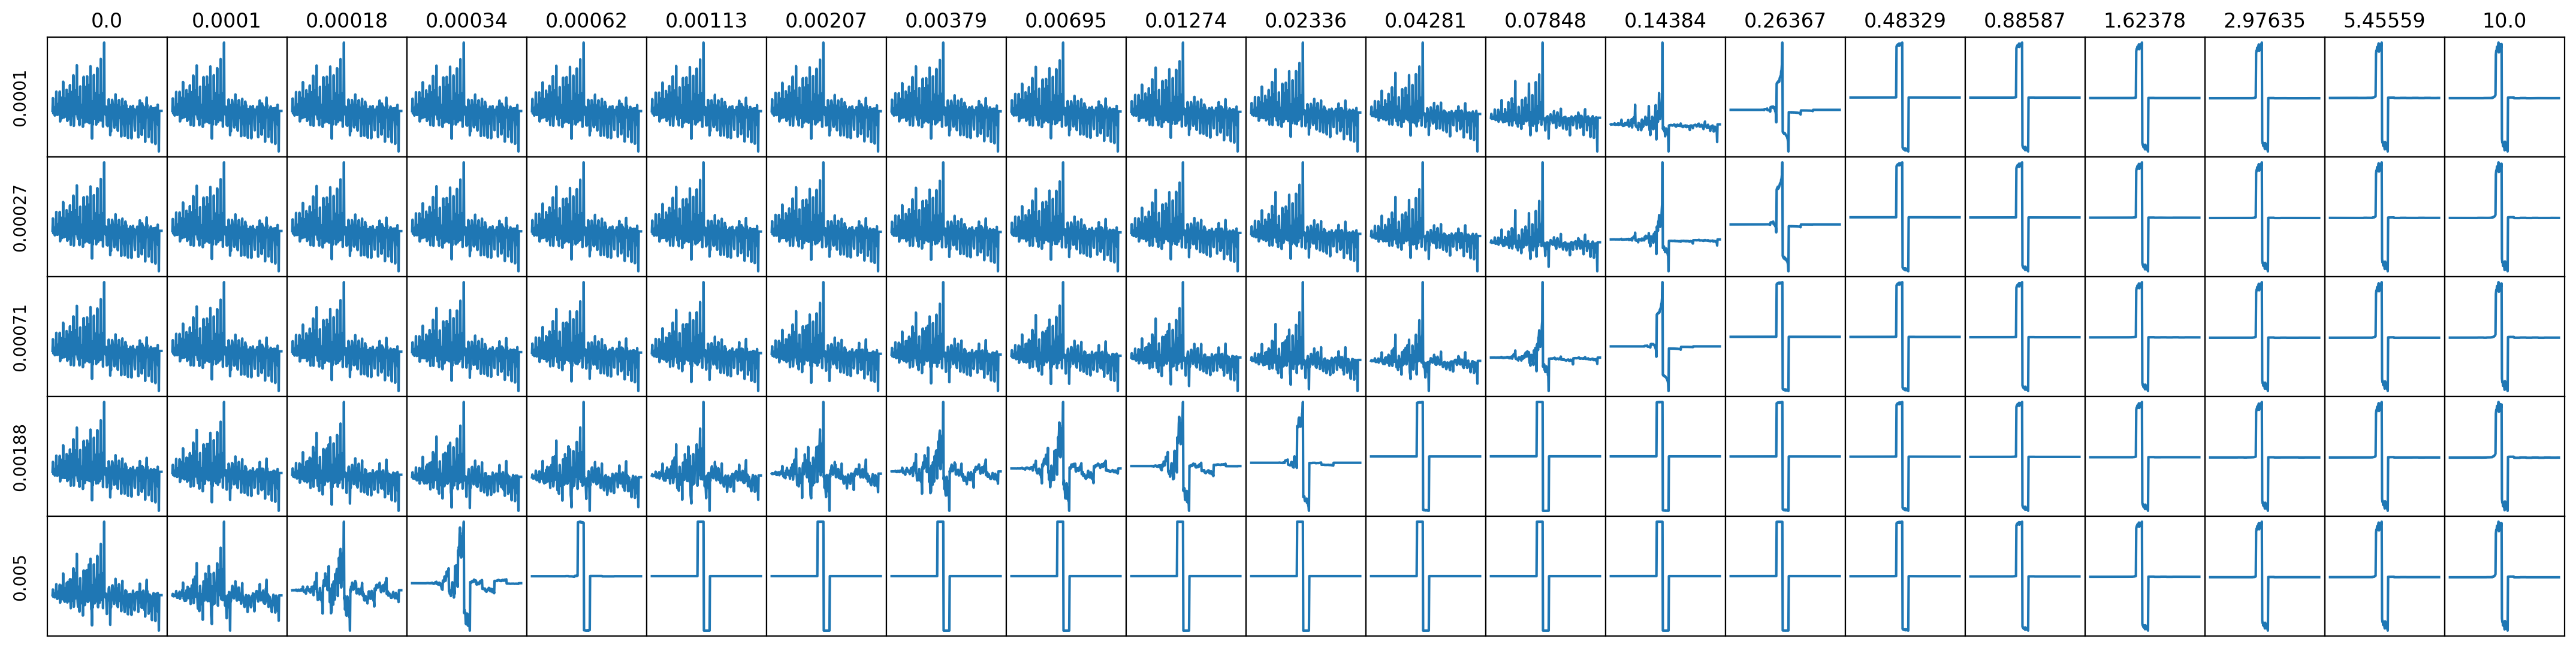

In [4]:
plt.figure(figsize=(C+1, R+1), dpi=200)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

i = 0
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, psi_list[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamL1wave_grid[r]))
        if r == 0:
            plt.title(str(lamL1attr_grid[c]))
        i += 1
plt.show() 


# calculate accuracy

In [5]:
def dataloader_to_nparrays(w_transform, train_loader, test_loader):
    w_transform = w_transform.to('cpu')
    J = w_transform.J
    X = []
    y = []
    for data, labels in train_loader:
        data_t = w_transform(data)
        for j in range(J+1):
            if j == 0:
                a = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
                b = deepcopy(-torch.max(-data_t[j].detach(), dim=2)[0])
#                 x = a
                f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
                x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f
                x = x1[:,None]
            else:
                a = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
                b = deepcopy(-torch.max(-data_t[j].detach(), dim=2)[0])                
#                 x = torch.cat((x, a), axis=1)    
                f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
                x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f
                x = torch.cat((x,x1[:,None]), axis=1)
        X.append(x)
        y.append(labels)
    X = torch.cat(X).squeeze().numpy()
    y = torch.cat(y).squeeze().numpy()

    X_test = []
    y_test = []
    for data, labels in test_loader:
        data_t = w_transform(data)
        for j in range(J+1):
            if j == 0:
                a = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
                b = deepcopy(-torch.max(-data_t[j].detach(), dim=2)[0])
#                 x = a  
                f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
                x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f
                x = x1[:,None]
            else:
                a = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
                b = deepcopy(-torch.max(-data_t[j].detach(), dim=2)[0])                
#                 x = torch.cat((x, a), axis=1)  
                f = -2*torch.max(torch.cat((a,-b),axis=1),dim=1)[1] + 1
                x1 = torch.max(torch.cat((a,-b),axis=1),dim=1)[0] * f
                x = torch.cat((x,x1[:,None]), axis=1)
        X_test.append(x)
        y_test.append(labels)
    X_test = torch.cat(X_test).squeeze().numpy()
    y_test = torch.cat(y_test).squeeze().numpy()   
    
    return (X, y), (X_test, y_test)

In [6]:
reg = []
log = []
for use_reg in [True, False]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                                 batch_size=p.batch_size,
                                                 is_continuous=use_reg)   
    for i,wt in enumerate(wt_list):
        wt = wt.to('cpu')
        (X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)
        
        if use_reg:
            clf = LinearRegression().fit(X, y)
            preds = clf.predict(X_test)
            error = metrics.r2_score(y_test, preds)
            reg.append(error)
        else:
            clf = LogisticRegression().fit(X, y)
            preds = clf.predict(X_test)
            preds = 1 * (preds > 0)
            error = metrics.accuracy_score(y_test, preds)
            log.append(error)
        print('\r {}'.format(i), end='')
reg = np.array(reg)
log = np.array(log)  

 104

Hyperparameter: lamL1wave=0.000710 lamL1attr=0.078480
Error: Recon=0.000002
Sparsity: Wave=5.547222
Interp: Saliency=0.430594 InputXGrade=0.338795
Wavelet loss: lSum=0.000000 hsum=0.000077 L2norm=0.000000 CMF=0.000000 Conv=0.000000


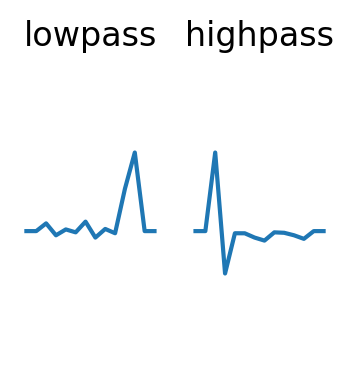

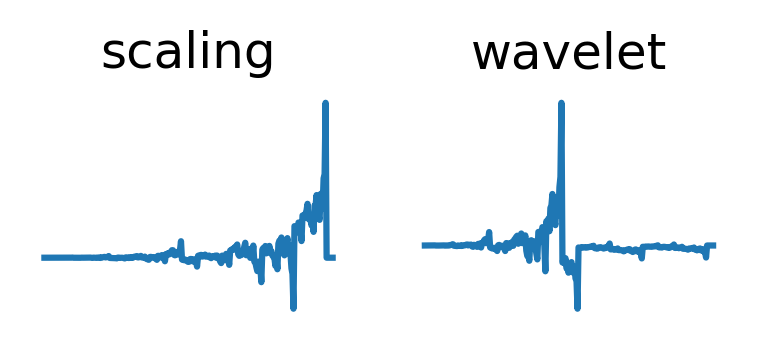

In [7]:
# idx1, idx2 = index2t[np.argmax(reg).flatten()[0]]
idx1, idx2 = index2t[np.argmax(log).flatten()[0]]
wt = mos[index2o[(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index2o[(idx1, idx2)]], res['lamL1attr'][index2o[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index2o[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index2o[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index2o[(idx1, idx2)]], res['L1inputxgrad_loss'][index2o[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index2o[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index2o[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index2o[(idx1, idx2)]],
                                                                                          res['conv_loss'][index2o[(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

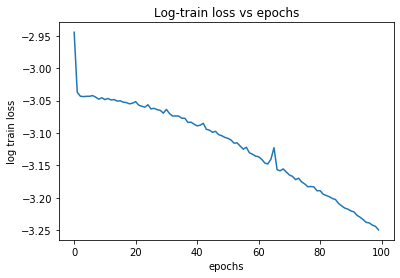

In [8]:
plt.plot(np.log(res['train_losses'][index2o[(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [14]:
# idx1, idx2 = index2t[np.argmax(reg).flatten()[0]]
idx1, idx2 = index2t[np.argmax(log).flatten()[0]]
wt = mos[index2o[(idx1, idx2)]]
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
model = load_pretrained_model(p.model_path, device=device)    

r = {
    'Standard Wavelet (Sym5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}

for use_reg in [True, False]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                 batch_size=p.batch_size,
                                 is_continuous=use_reg)   


    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)
    
    if use_reg:
        clf = LinearRegression().fit(X, y)
        preds = clf.predict(X_test)
        error = metrics.r2_score(y_test, preds)
    else:
        clf = LogisticRegression().fit(X, y)
        preds = clf.predict(X_test)
        preds = 1 * (preds > 0)
        error = metrics.accuracy_score(y_test, preds)
    r['AWD (Ours)'].append(error)

    wt_o = wt_o.to('cpu')
    (X, y), (X_test, y_test) = dataloader_to_nparrays(wt_o, train_loader, test_loader)
    if use_reg:
        clf_o = LinearRegression().fit(X, y)
        preds = clf_o.predict(X_test)
        error = metrics.r2_score(y_test, preds)
    else:
        clf_o = LogisticRegression().fit(X, y)
        preds = clf_o.predict(X_test)
        preds = 1 * (preds > 0)
        error = metrics.accuracy_score(y_test, preds)
    r['Standard Wavelet (Sym5)'].append(error)

    preds = []
    y = []
    for data, labels in test_loader:   
        preds.append(model(data).detach().numpy())
        y.append(labels.detach().numpy())
    preds = np.vstack(preds)
    y = np.vstack(y)
    if use_reg:
        error = metrics.r2_score(y_test, preds)
    else:
        preds = 1 * (preds > 0)
        error = metrics.accuracy_score(y_test, preds)
    r['LSTM'].append(error)
scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Regression (R2 score)', 'Classification accuracy']

In [15]:
print(scores.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (Sym5) &  AWD (Ours) &   LSTM \\
\midrule
Regression (R2 score)   &                    0.204 &       0.214 &  0.237 \\
Classification accuracy &                    0.706 &       0.703 &  0.709 \\
\bottomrule
\end{tabular}



# transfer to full data

In [11]:
# df = pd.read_pickle(opj(p.data_path, 'df_full.pkl'))
# df = preprocessing.features.normalize_track(df, track='X_same_length', by_time_point=False) # adds X_same_length_normalized
# df = df[~df.short & ~df.hotspots] # filter out easy/invalid tracks

In [12]:
# dset_names = sorted(df['dset'].unique())
# ks = []
# for d in dset_names:
#     ks += [f'r2', f'r2_wt', f'r2_wt_o',
#            f'acc', f'acc_wt', f'acc_wt_o',]
# scores = {
#     k: [] for k in ks
# }
#     # test on all test sets
# for test_set_name in dset_names:
#     d = df[(df['dset'] == test_set_name) & (df['split'] == 'test')]
#     X = torch.Tensor(np.vstack(d['X_same_length_normalized'].values))

#     preds_reg = model(X).flatten()
#     preds_class = (preds_reg > 0).numpy().astype(int)
#     # preds_reg_dasc = dasc_model.predict(d['X_d1'].values.reshape(-1, 1))
#     coefs = wt(X.unsqueeze(0))
#     coefs_max = np.vstack([np.max(coefs[i].detach().numpy(), axis=2).flatten()
#             for i in range(len(coefs))]).T
#     preds_wt = clf.predict(coefs_max)
#     preds_class_wt = (preds_wt > 0).astype(int)
    
   
#     coefs = wt_o(X.unsqueeze(0))
#     coefs_max = np.vstack([np.max(coefs[i].detach().numpy(), axis=2).flatten()
#             for i in range(len(coefs))]).T
#     preds_wt_o = clf_o.predict(coefs_max)
#     preds_class_wt_o = (preds_wt_o > 0).astype(int)
   
#     scores[f'r2'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_reg))
#     scores[f'acc'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class))
    
#     print('shapes', d.shape, preds_reg.shape, preds_wt.shape)
#     scores[f'r2_wt'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_wt))
#     scores[f'acc_wt'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class_wt))
    
#     scores[f'r2_wt_o'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_wt_o))
#     scores[f'acc_wt_o'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class_wt_o))    
# #     print(scores)
# scores = pd.DataFrame.from_dict(scores)
# scores.index = dset_names
# scores

In [13]:
# scores.round(2).style.background_gradient()